In [147]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display
from scipy.stats import iqr

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select Exp1 or Exp2


In [148]:
EXPERIMENT = "Exp1"

# Initial Thangs


In [149]:
plt.style.use("cashaback_dark")
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['figure.titlesize'] = 35
mpl.rcParams['font.size'] = 20



wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}")
it = InitialThangs(EXPERIMENT)

# Pickle Data and Models

In [150]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
    
model_path = Path(f'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}\\models')

model_description_dfs = list(model_path.glob(f"{EXPERIMENT}_model_descriptions*"))
model_parameter_dfs = list(model_path.glob(f"{EXPERIMENT}_model_parameters*"))
df_description = pd.read_pickle(model_description_dfs[-1])
df_params = pd.read_pickle(model_parameter_dfs[-1])
df_description['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
df_params['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)


In [174]:

# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Agent_SD==False and Known_Guess_SD==False and Known_Switch_Delay==False and Incorrect_Cost == "Less" and Parameters==4)')['Model'])
# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Switch_Delay==False and Parameters==1)')['Model'])
model_names_from_df = list(df_description.query('Parameters == 0')['Model'])
base_model_df = df_params[df_params['Model'].isin(model_names_from_df)]
base_model_df = base_model_df.sort_values('Parameters')
model_names = ['Theoretical Optimal', 'Theoretical Optimal\n(Not Accounting for Switch Delay)', "Blah", "Blah"]
display(base_model_df)
models = {}
for i, (index, row) in enumerate(base_model_df.iterrows()):
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd+5, # This includes electromechanical delay sd and timing sd bc it's straight from data
        # guess_sd=row.guess_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=True,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 23
    )
    models.update({model_names[i]:model})

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters
240,model240_2023_09_18_13_51_02,10.034863,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1


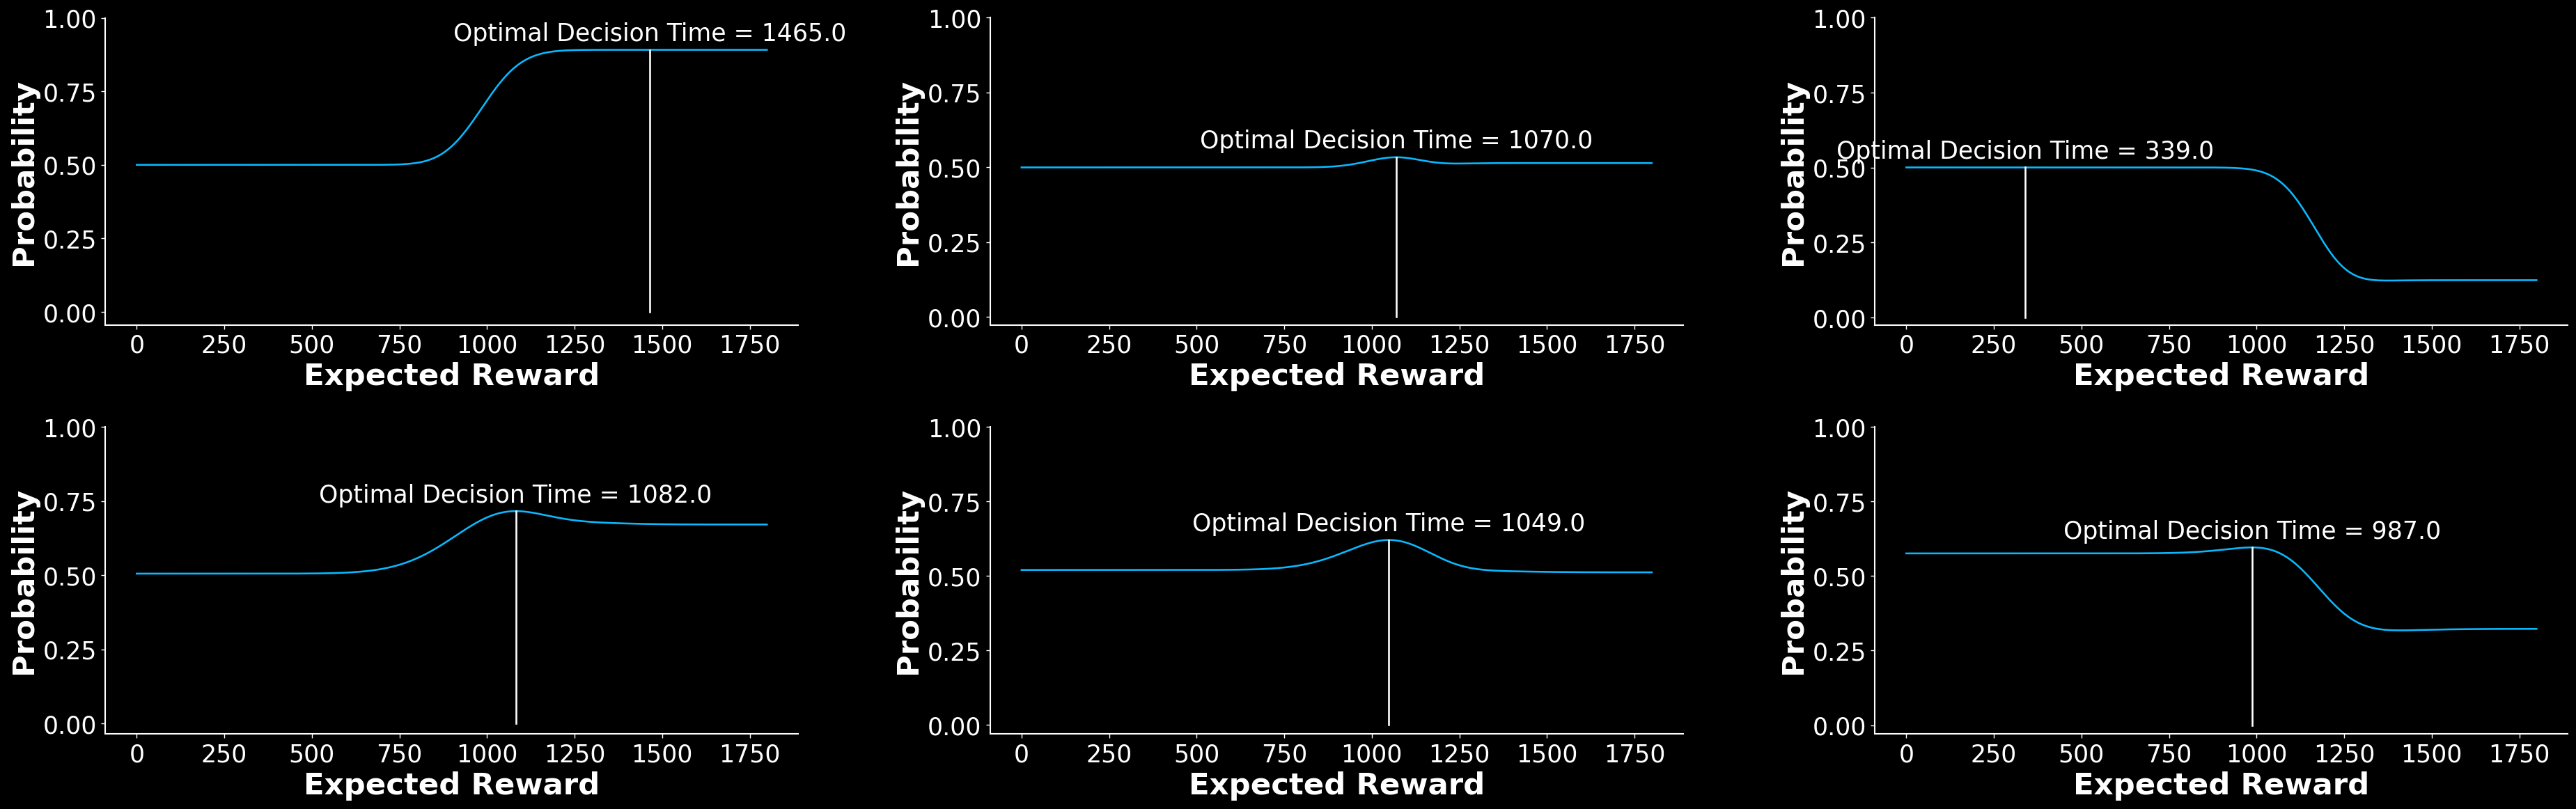

In [175]:
model.plot_optimals(['exp_reward'],titles=[None]*6,xlabel='Expected Reward',dpi=300,figsize=(30,10))

# Run Stats and Plot

In [191]:
#
#* Set plot constants
SHOW_BOXPLOTS = True
SHOW_MODELS = True
SHOW_STATS = True
w,h = 13,8
mult_w, div_w = 0.9,1.1
div_h = 1.1
bw = (0.35*w)/it.num_blocks # box widths of all boxes combined takes up 30% of the width
xlocs = np.linspace(0, w/div_w - 0.5, num=len(it.trial_block_titles))
legend_fontsize = 18
title_fontsize = 35
#* Get dataframe and create the stats inputs
df = st.generate_dataframe(group, EXPERIMENT, DROP_SUBJECT_NUM=13)
# display(df)

stats_inputs = st.Inputs(
    df, experiment = EXPERIMENT, num_subjects = len(df['Subject'].unique()), 
    num_blocks=it.num_blocks,num_trials=it.num_trials,
    trial_block_titles=it.trial_block_titles,xlab=it.xlabel,
    f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,
    f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
    M = 1e7
)

!! DROPPING SUBJECT 13 !! 


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


## Median Movement Onset 

### Stats

In [192]:
median_movement_onset_anova = st.Anova('Median_Movement_Onset_Time', stats_inputs)
display(median_movement_onset_anova.anova)
median_movement_onset_boot = st.Bootstrap(stats_inputs, median_movement_onset_anova,no_collapse=True,
                                          alternative='variable',test='mean')
median_movement_onset_statistics = median_movement_onset_boot.run_bootstrap()
median_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,20692.000000,2,36,10346.000000,4.769131,0.014544,0.024551,0.021310,0.755194
1,Factor_2,30756.633772,1,18,30756.633772,8.020700,0.011049,0.011049,0.031350,1.000000
2,Factor_1 * Factor_2,2146.859649,2,36,1073.429825,0.483197,0.620751,0.580169,0.002254,0.800707


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.0328344,
  '04': 0.7304133,
  '13': 0.08094950000000001,
  '15': 0.5741542,
  '24': 0.28932,
  '35': 0.0896012},
 {'02': 68.42105263157895,
  '04': 63.1578947368421,
  '13': 73.68421052631578,
  '15': 52.63157894736842,
  '24': 57.89473684210527,
  '35': 63.1578947368421}]

### Plot

In [193]:
xlocs

array([ 0.        ,  2.26363636,  4.52727273,  6.79090909,  9.05454545,
       11.31818182])

0.7583333333333333


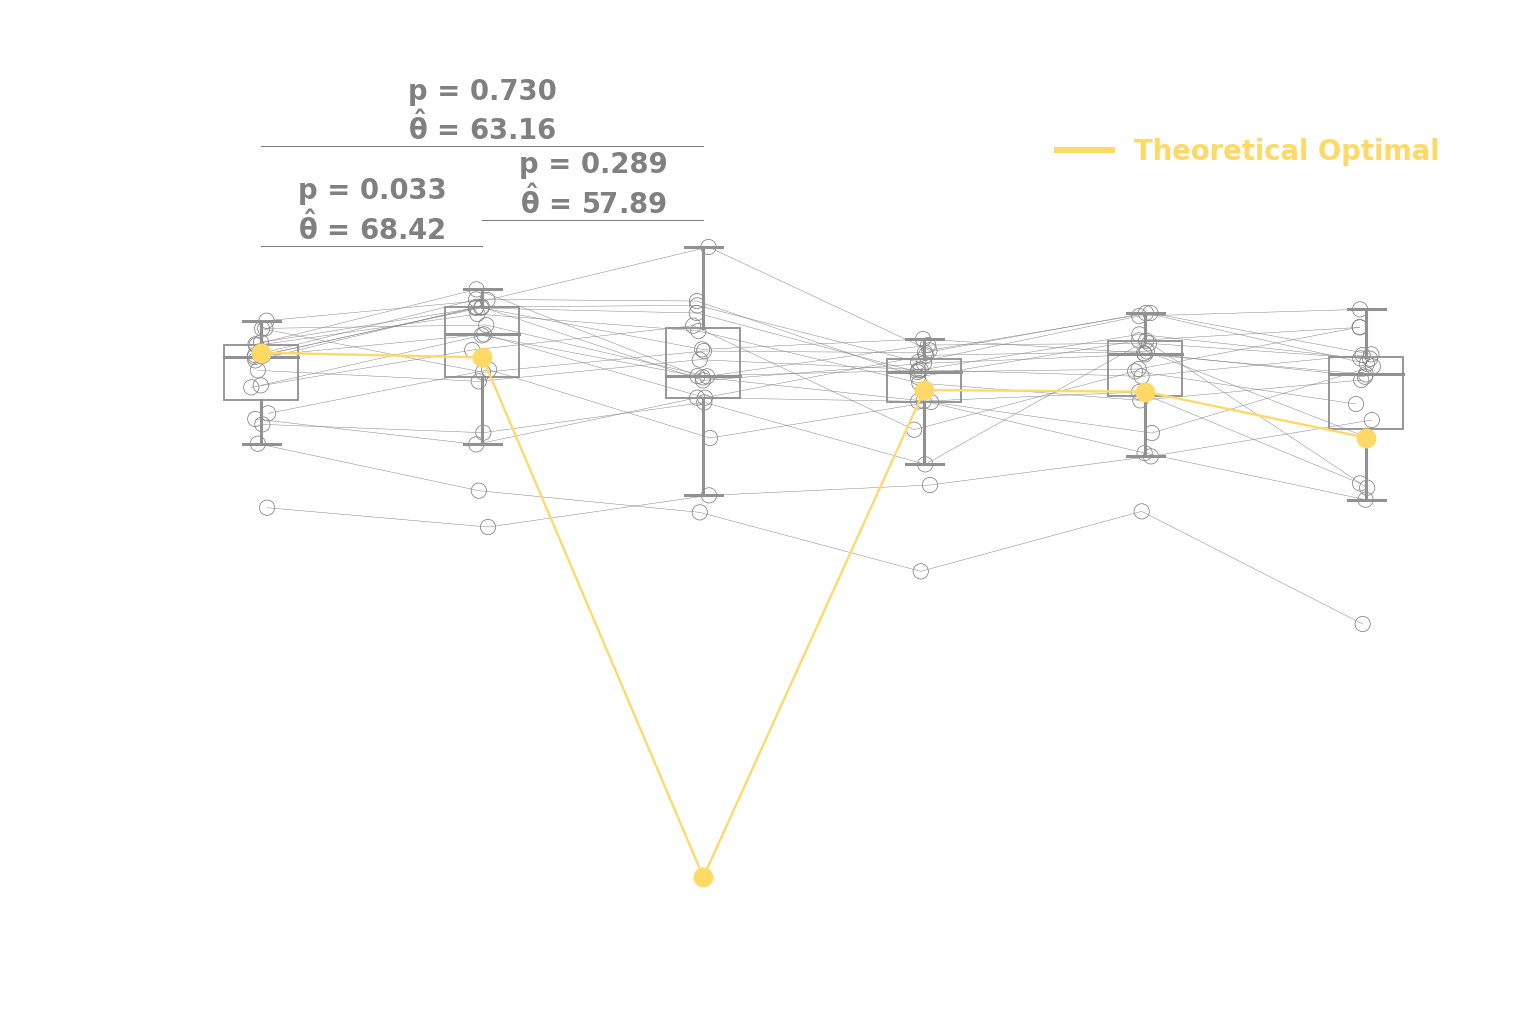

In [194]:


if True:
    metric = st.df_to_array(df['Median_Movement_Onset_Time'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    ylocs = np.arange(200, 1601, 200)
    ylabel = 'Time (ms)'
    title = 'Median Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in models.values()]
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=list(models.keys()),
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=title_fontsize,
            title_padding=40,
        )
    ax.set_ylim(400,1600)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(ax,stats_inputs=stats_inputs, statistics=median_movement_onset_statistics,
                    combos = ['02','24','04',],xlocs=xlocs, 
                    xloc_index = ['01','12','02',], 
                    ypos=[1401,1440,1550,1420,1490],
                    fontsize=18,stacked=True
                        )
    
    fig.remove_figure_borders()
print(bw)

## Indecisions

In [195]:
indecisions_anova = st.Anova('Indecisions', stats_inputs)
display(indecisions_anova.anova)
indecisions_boot = st.Bootstrap(stats_inputs, indecisions_anova,no_collapse=True,alternative='two-sided')
indecisions_statistics = indecisions_boot.run_bootstrap()
indecisions_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,1968.092105,2,36,984.046053,9.374886,0.000528,0.001958,0.108438,0.740902
1,Factor_2,7.894737,1,18,7.894737,0.133953,0.718634,0.718634,0.000488,1.000000
2,Factor_1 * Factor_2,1043.421053,2,36,521.710526,6.420331,0.004125,0.007490,0.060577,0.814409


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.0,
  '04': 0.0053945,
  '13': 0.1556284,
  '15': 1.0,
  '24': 1.0,
  '35': 0.5251872},
 {'02': 84.21052631578947,
  '04': 78.94736842105263,
  '13': 60.526315789473685,
  '15': 60.526315789473685,
  '24': 57.89473684210527,
  '35': 68.42105263157895}]

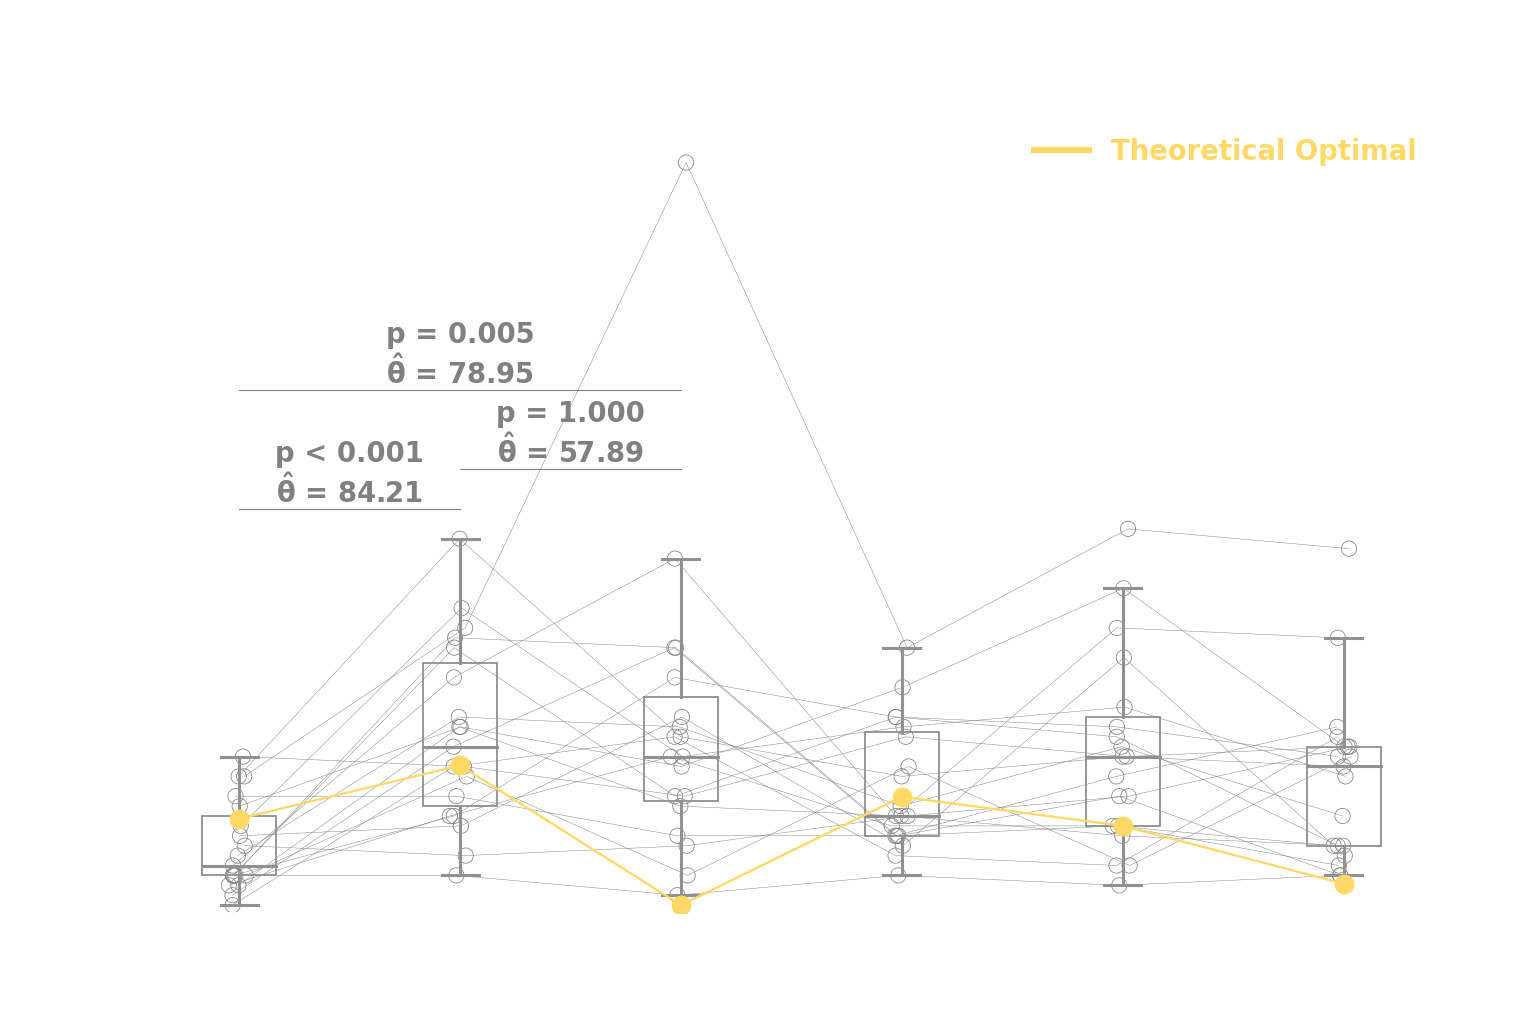

In [196]:
if True:
    metric = st.df_to_array(df['Indecisions'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    ylocs = np.arange(0, 101, 25)
    ylabel = 'Percent (%)'
    title = 'Indecisions' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.score_metrics.prob_indecision, metric_type='true',decision_type='optimal')*100 for model in models.values()]
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=list(models.keys()),
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=title_fontsize,
            title_padding=40,
        )
    ax.set_ylim(-1,100)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(
            ax,stats_inputs=stats_inputs, statistics=indecisions_statistics,
            combos = ['02','24','04',],xlocs=xlocs, 
            xloc_index = ['01','12','02',], 
            ypos=[50,55,65,1420,1490],
            fontsize=18,stacked=True
        )
    
    fig.remove_figure_borders()


## SD Movement Onset

In [197]:
# if True:
#     xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
#     legend_fontsize = 10

#     metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
#     # metric = iqr(group.movement_metrics.movement_onset_times('task'), axis=2,nan_policy='omit')
#     ylocs = np.arange(0, 201, 50)
#     ylabel = 'Time (ms)'
#     title = 'SD Movement Onset Time' 

#     fig = dv.Figure(figsize=(w, h), dpi=110)
#     ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
#     model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal') for model in models.values()]

#     bw = 0.3*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width

#     pf.multiple_models_boxplot(
#             ax=ax,
#             data=metric,
#             box_width = bw,
#             model_data=model_data,
#             labels=list(models.keys()),
#             show_boxplot=True,
#             colors=wheel.grey,
#             linestyles=None,
#             line_colors = None,
#             xlocs=xlocs,
#             ylocs=ylocs,
#             xticklabels=it.trial_block_titles,
#             xlabel=it.xlabel,
#             ylabel=ylabel,
#             title=title,
#             legend_fontsize=legend_fontsize,
#             title_fontsize=20
#         )